In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from collections import Counter
from src.utils import data_load
import pandas as pd
import matplotlib.pyplot as plt
from src.s3_utils import pandas_from_csv_s3
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import re
import datetime
import seaborn as sns
import numpy as np
from collections import defaultdict
import os
import pickle
import matplotlib.font_manager as fm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-n6u1q404 because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
keys = {'oura_sleep', 'oura_activity', 'oura_readiness', 'birth'}
data = data_load(data_keys=keys, wave=5)

In [3]:
df_birth = data['birth']

In [51]:
def getUser(df, user, variable):
    dfUser = df[df.user_id == user]
    dfUser = dfUser.set_index('daysSince')
    dfUser = dfUser.resample('1D')[variable].mean()
    dfUser.name = 'value'
    dfUser = dfUser.reset_index('daysSince')
    dfUser['daysSince'] = (dfUser['daysSince'] / np.timedelta64(1, 'D')).astype(int)
    return dfUser

def findDaysSince(df):
    
    df2 = []
   
    # for every unique user
    for user_id in df.user_id.unique():
        
        if (len(df_birth.loc[df_birth.user_id == user_id]) != 0):
            birth = df_birth.loc[df_birth.user_id == user_id].reset_index()
            birthDate = birth['date'][0]
            # If the birth date is not null
            if (pd.isnull(birthDate) == False):
                # Get individual dataframe
                userDF = df[df['user_id'] == user_id]
                # For every date in the dataframe, add a new column value for days since birth
                userDF['daysSince'] = userDF.apply(lambda row: row.date - birthDate, axis=1)
                df2.append(userDF)
    return pd.concat(df2, ignore_index=True)

def bumpFigSingle(df1, v1, ylabel, fileName, ymin=None, ymax=None):
    
    # fig = plt.figure(figsize=(12,4))
    fig, ax = plt.subplots(figsize=(12,4))

    palette = sns.color_palette('muted')

    plt.rcParams.update({'figure.max_open_warning': 0})
    sns.set_theme(style='darkgrid')
    
    df1 = findDaysSince(df1)
    
    totalDF1 = pd.DataFrame(columns = ['daysSince', 'value', 'processed_value'])
    
    for user in df1.user_id.unique():
        dfUser1 = getUser(df1, user, v1)
        # dfUser1['impute_value'] = dfUser1.interpolate(method='linear')['value'].tolist()
        impute_value = dfUser1.interpolate(method='linear')['value'].tolist()
        processed_value = savgol_filter(np.array(impute_value), 6, 3)
        dfUser1['processed_value'] = processed_value.tolist()
        # print(dfUser1)
        # df = dfUser1.T.reset_index(drop=True)  # transpose dataframe
        # df = df.reindex(df.index.union(pd.np.linspace(df.index.min(),df.index.max(), df.index.shape[0]*10))).reset_index(drop=True)  # insert 10 "empty" points between existing ones
        # df = df.interpolate(method='linear')
        # sns.lineplot(data=dfUser1, x='daysSince', y='processed_value', ci=None, color='mediumpurple', alpha=0.2, markers='-o')
        totalDF1 = totalDF1.append(dfUser1)
    totalDF1 = totalDF1.dropna()
    totalDF1_min = totalDF1.groupby('daysSince').min()
    totalDF1_max = totalDF1.groupby('daysSince').max()
    ax.fill_between(np.sort(totalDF1.daysSince.unique().astype(np.float)), totalDF1_min['processed_value'].to_numpy(), totalDF1_max['processed_value'].to_numpy(), color='b', alpha=.3)
    totalDF1_mean = totalDF1.groupby('daysSince').mean()

    sns.lineplot(data=totalDF1_mean, x='daysSince', y='value', linewidth=2, ci=None, color='black', linestyle="dashed", label='Mean')
    
    plt.xlim(-250, 100)
    
    
    plt.ylabel(ylabel)
#     plt.set_title('Oura Sleep Heart Rate', fontproperties = fm.FontProperties(fname=path, size=15))
    plt.ylim(ymin, ymax)

    plt.xlabel('Days leading up to and after birth')
    
    
    fig.tight_layout()
#     plt.savefig('BUMP Paper Figures/Figure 1/Figure2_Bodyport_' + fileName + '.png')
    fig.show()

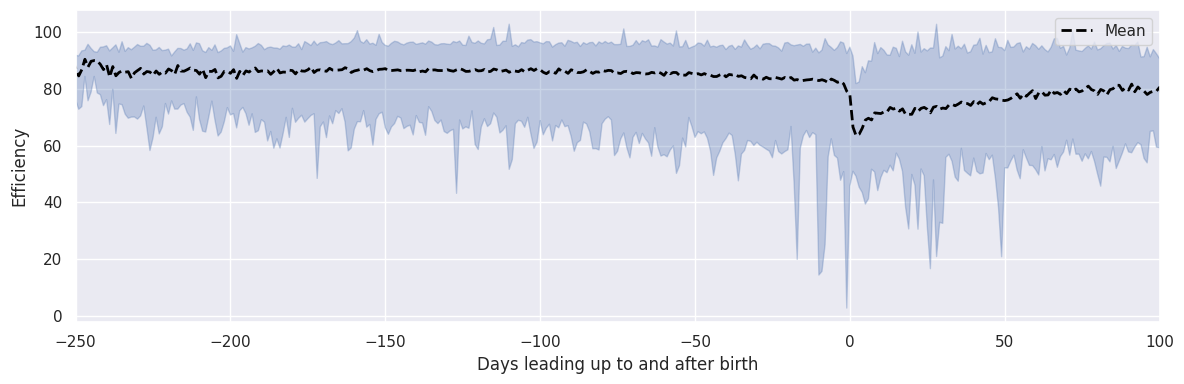

In [50]:
bumpFigSingle(data['oura_sleep'], 'efficiency', 'Sleep Efficiency', 'test', ymin=None, ymax=None)

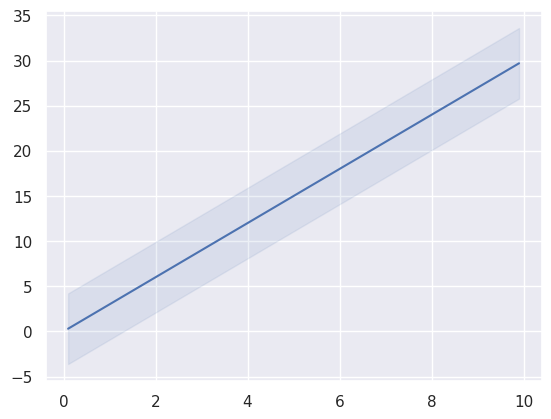

In [28]:
from matplotlib import pyplot as plt
import numpy as np

#some example data
x = np.linspace(0.1, 9.9, 20)
y = 3.0 * x
#some confidence interval
ci = 1.96 * np.std(y)/np.sqrt(len(x))

fig, ax = plt.subplots()
ax.plot(x,y)
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

In [25]:
type(y+ci)

numpy.ndarray

In [24]:
y+ci

array([ 4.21048503,  5.75785345,  7.30522187,  8.85259029, 10.39995872,
       11.94732714, 13.49469556, 15.04206398, 16.5894324 , 18.13680082,
       19.68416924, 21.23153766, 22.77890608, 24.3262745 , 25.87364293,
       27.42101135, 28.96837977, 30.51574819, 32.06311661, 33.61048503])